In [1]:
#import modules for images
import matplotlib.image as mtimg
import matplotlib.pyplot as pyplt
#numpy
import numpy as np
#importing opencv for perspective transform step
import cv2

In [2]:
%matplotlib inline
#the image will be displayed in a non-interactive mode

In [3]:
# Creating a function to apply color thresholding to seperate traversable terrain from the mountains

def color_thresh(image):
    rgb_thresh = [140,140,160]
    x,y,z = image.shape
    thresh_img = np.zeros_like(image[:,:,0])
    for i in range(x):
        for j in range(y):
            if image[i,j,0] > rgb_thresh[0] \
            and image[i,j,1] > rgb_thresh[1] \
            and image[i,j,2] > rgb_thresh[2]:
                thresh_img[i,j] = 1
            else:
                thresh_img[i,j] = 0
    return thresh_img

In [4]:
def pers_tr(img,src):
    src_pts = np.float32(src)
    #destination points: any image would be transformed into a 10x10 top-down view image 
    dst = np.float32([[img.shape[1]/2 - 5, img.shape[0] - 5 - 6 ], \
                     [img.shape[1]/2 + 5, img.shape[0] - 5 - 6 ], \
                     [img.shape[1]/2 + 5, img.shape[0] + 5 - 6 ], \
                     [img.shape[1]/2 - 5, img.shape[0] + 5 - 6 ] ])
    #dst_pts = np.float32([[155,70], [165,70], [165,80], [155,80]])
#dst_pts = np.float32([[0,0], [grid_img.shape[1]/2,0], [grid_img.shape[1]/2,grid_img.shape[0]/2], [0,grid_img.shape[0]/2]])
    
    #finding the transformation matrix M
    M = cv2.getPerspectiveTransform(src_pts,dst)
    
    #performing transformation
    warped = cv2.warpPerspective(img,M,(img.shape[1], img.shape[0]))
    return warped

In [5]:
def robo_coord(img):
    ypos, xpos = img.nonzero()
    #pyplt.plot(xpos,ypos,'.')
    ypos1 = -(ypos - 160)
    xpos1 = xpos - 160
#     pyplt.plot(xpos1,ypos1,'.')
#     pyplt.ylim(0,160)
#     pyplt.xlim(-160,160)
    
    return xpos1, ypos1

In [6]:
def rot_pix(x,y,theta):
    # covert the angle from degree to radian
    theta_rad = theta * np.pi / 180
    x_rot = (x * np.cos(theta_rad)) - (y * np.sin(theta_rad))
    y_rot = (x * np.sin(theta_rad)) + (y * np.cos(theta_rad))
    
    return x_rot,y_rot

In [7]:
def translate_pix(x_rot, y_rot, xpos, ypos, scale):
    
    x_trans = xpos + (x_rot / scale)
    y_trans = ypos + (y_rot / scale)

    
    return x_trans, y_trans

In [8]:
def pix_to_world(xpix, ypix, xpos, ypos, theta, world_size, scale):
    
    x_r, y_r = rot_pix(xpix, ypix, theta)
    x_t, y_t = translate_pix(x_r, y_r, xpos, ypos, scale)
        
    # Clip to world_size
    x_pix_world = np.clip(np.int_(x_t), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(y_t), 0, world_size - 1)
    
    return x_pix_world, y_pix_world

In [9]:
def rect_to_polar(xpix,ypix):
    dist = np.sqrt((xpix**2) + (ypix**2))
    angles = np.arctan2(ypix,xpix)
    return dist,angles

In [10]:
env_img = mtimg.imread("heading_img.jpg")
ct_img = color_thresh(env_img)
src_pts = np.float32([[118,96], [200,96], [302,140], [13.3,140]]) # coordinates chosen from the image
warped_img = pers_tr(ct_img, src_pts)
xpix, ypix = robo_coord(warped_img)
distances,angles = rect_to_polar(xpix,ypix)
avg_angles = np.mean(angles)
avg_angle_degrees = avg_angles * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)

Xpos = [30.77301417] Ypos = [82.16016002] Yaw = [115.3585324]


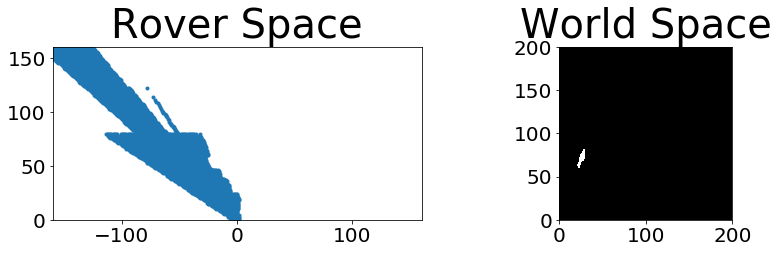

In [12]:
# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
theta = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20


# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, theta, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', theta)
# Plot the map in rover-centric coords

f, (ax1, ax2) = pyplt.subplots(1, 2, figsize=(12, 3))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_xlim(-160, 160)
ax1.set_ylim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


pyplt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)

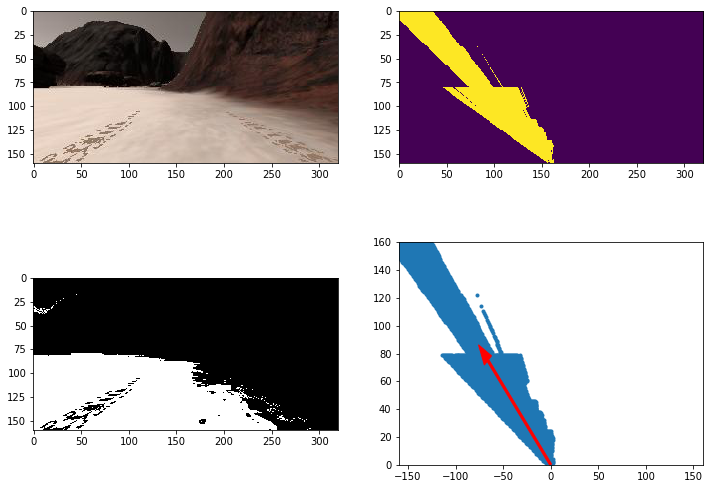

In [13]:
# plotting
fig = pyplt.figure(figsize=(12,9))
pyplt.subplot(221)
pyplt.imshow(env_img)
pyplt.subplot(222)
pyplt.imshow(warped_img)
pyplt.subplot(223)
pyplt.imshow(ct_img, cmap='gray')
pyplt.subplot(224)
pyplt.plot(xpix, ypix, '.')
pyplt.xlim(-160, 160)
pyplt.ylim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angles)
y_arrow = arrow_length * np.sin(avg_angles)
pyplt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
pyplt.show()

In [ ]:
# # choosing the destination points
# def dest_pts(pts):
#     tl,tr,br,bl = pts
#     rect = np.zeros((4,2), dtype = 'float32')
    
#     w_bottom = np.sqrt(((br[0]-bl[0])**2) + ((br[1]-bl[1])**2))
#     w_top = np.sqrt(((tr[0]-tl[0])**2) + ((tr[1]-tl[1])**2))
    
    
#     h_left = np.sqrt(((bl[0]-tl[0])**2) + ((bl[1]-tl[1])**2))
#     h_right = np.sqrt(((br[0]-tr[0])**2) + ((br[1]-tr[1])**2))
    
#     max_width = max(w_bottom,w_top)
#     max_height = max(h_left,h_right)
    
#     rect = np.array([[0,0],[max_width-1,0],[max_height-1,0],[max_width,max_height]],dtype = "float32")
#     return rect